In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [28]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [29]:
train = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\train.csv")
test = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\test.csv")
alldata = pd.concat([train,test])
alldata

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,NaN


In [30]:
alldata["u-g"] = alldata["u"]-alldata["g"]
alldata["g-r"] = alldata["g"]-alldata["r"]
alldata["r-i"] = alldata["r"]-alldata["i"]
alldata["i-z"] = alldata["i"]-alldata["z"]

alldata["d1"] = alldata["dered_u"]-alldata["dered_g"]
alldata["d2"] = alldata["dered_g"]-alldata["dered_r"]
alldata["d3"] = alldata["dered_r"]-alldata["dered_i"]
alldata["d4"] = alldata["dered_i"]-alldata["dered_z"]

alldata["minusOD"] = alldata["nObserve"] - alldata["nDetect"] # 6553
alldata["plusOD"] = alldata["nObserve"] + alldata["nDetect"]

alldata["d5"] = alldata["u"]-alldata["r"] # 6591  
alldata["d6"] = alldata["u"]-alldata["i"] # 6648   
alldata["d7"] = alldata["u"]-alldata["z"]  # 6548   
alldata["d8"] = alldata["g"]-alldata["i"] # 6639   
alldata["d9"] = alldata["g"]-alldata["z"] # 6608   
alldata["d10"] = alldata["r"]-alldata["z"] # 6614   
alldata['d11'] = alldata['dered_u'] - alldata['dered_z'] # 6595

alldata['d_dered_ig'] = alldata['dered_i'] - alldata['dered_g'] # 6605
alldata['d_dered_zg'] = alldata['dered_z'] - alldata['dered_g'] # 6641
alldata['d_dered_rz'] = alldata['dered_r'] - alldata['dered_z'] # 6641

alldata

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,u-g,g-r,r-i,i-z,d1,d2,d3,d4,minusOD,plusOD,d5,d6,d7,d8,d9,d10,d11,d_dered_ig,d_dered_zg,d_dered_rz
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,2.9272,1.3273,1.3371,0.7328,2.8665,1.3027,1.3230,0.7232,0,36,4.2545,5.5915,6.3243,2.6643,3.3972,2.0699,6.2153,-2.6257,-3.3488,2.0462
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,0.9902,0.6096,0.1840,0.0995,0.9619,0.5931,0.1751,0.1016,0,2,1.5997,1.7837,1.8832,0.7935,0.8930,0.2835,1.8317,-0.7683,-0.8698,0.2767
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,0.9610,0.2891,0.1428,0.0435,0.9211,0.2466,0.1183,0.0257,0,4,1.2501,1.3928,1.4364,0.4319,0.4754,0.1863,1.3116,-0.3649,-0.3905,0.1440
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0,4.4719,0.9676,0.3262,0.2603,4.3590,0.9074,0.2926,0.2395,1,7,5.4395,5.7657,6.0260,1.2938,1.5541,0.5865,5.7985,-1.2000,-1.4395,0.5321
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0,3.7543,1.6568,0.7182,0.3415,3.3376,1.5709,0.6727,0.3144,1,25,5.4111,6.1293,6.4708,2.3750,2.7165,1.0597,5.8955,-2.2436,-2.5579,0.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN,1.0117,0.3909,0.1483,0.0598,0.9428,0.3073,0.0999,0.0191,0,34,1.4026,1.5509,1.6107,0.5392,0.5990,0.2081,1.3692,-0.4072,-0.4263,0.1190
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN,0.7946,0.1196,-0.3962,0.1591,0.7594,0.0949,-0.4056,0.1680,4,12,0.9142,0.5180,0.6771,-0.2766,-0.1175,-0.2371,0.6167,0.3108,0.1428,-0.2376
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN,1.1580,0.0806,-0.0373,-0.0041,1.0383,-0.0294,-0.0996,-0.0357,0,2,1.2386,1.2013,1.1972,0.0433,0.0392,-0.0413,0.8736,0.1289,0.1647,-0.1353
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,NaN,1.2989,0.4680,0.3105,0.2278,1.2835,0.4323,0.2897,0.2075,0,34,1.7669,2.0774,2.3052,0.7785,1.0063,0.5383,2.2130,-0.7220,-0.9295,0.4972


In [31]:
alldata2 = alldata.drop(["id","class","airmass_u","airmass_g","airmass_r","airmass_i","airmass_z"], axis=1)
alldata2

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,u-g,g-r,r-i,i-z,d1,d2,d3,d4,minusOD,plusOD,d5,d6,d7,d8,d9,d10,d11,d_dered_ig,d_dered_zg,d_dered_rz
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,2.9272,1.3273,1.3371,0.7328,2.8665,1.3027,1.3230,0.7232,0,36,4.2545,5.5915,6.3243,2.6643,3.3972,2.0699,6.2153,-2.6257,-3.3488,2.0462
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,0.9902,0.6096,0.1840,0.0995,0.9619,0.5931,0.1751,0.1016,0,2,1.5997,1.7837,1.8832,0.7935,0.8930,0.2835,1.8317,-0.7683,-0.8698,0.2767
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,0.9610,0.2891,0.1428,0.0435,0.9211,0.2466,0.1183,0.0257,0,4,1.2501,1.3928,1.4364,0.4319,0.4754,0.1863,1.3116,-0.3649,-0.3905,0.1440
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,4.4719,0.9676,0.3262,0.2603,4.3590,0.9074,0.2926,0.2395,1,7,5.4395,5.7657,6.0260,1.2938,1.5541,0.5865,5.7985,-1.2000,-1.4395,0.5321
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,3.7543,1.6568,0.7182,0.3415,3.3376,1.5709,0.6727,0.3144,1,25,5.4111,6.1293,6.4708,2.3750,2.7165,1.0597,5.8955,-2.2436,-2.5579,0.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.0117,0.3909,0.1483,0.0598,0.9428,0.3073,0.0999,0.0191,0,34,1.4026,1.5509,1.6107,0.5392,0.5990,0.2081,1.3692,-0.4072,-0.4263,0.1190
79996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,0.7946,0.1196,-0.3962,0.1591,0.7594,0.0949,-0.4056,0.1680,4,12,0.9142,0.5180,0.6771,-0.2766,-0.1175,-0.2371,0.6167,0.3108,0.1428,-0.2376
79997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1580,0.0806,-0.0373,-0.0041,1.0383,-0.0294,-0.0996,-0.0357,0,2,1.2386,1.2013,1.1972,0.0433,0.0392,-0.0413,0.8736,0.1289,0.1647,-0.1353
79998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.2989,0.4680,0.3105,0.2278,1.2835,0.4323,0.2897,0.2075,0,34,1.7669,2.0774,2.3052,0.7785,1.0063,0.5383,2.2130,-0.7220,-0.9295,0.4972


In [32]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

In [33]:
x_train, x_valid, y_train, y_valid = train_test_split(train2, train["class"], test_size = 0.2, random_state = 42 )

In [38]:
# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
# p_val = np.zeros((train2.shape[0], 3))
# p_tst = np.zeros((train["class"].shape[0], 3))

# for i, (i_trn, i_val) in enumerate(cv.split(train2, train["class"]), 1):
#     print(f'training model for CV #{i}')
#     clf = RandomForestClassifier()    
#     clf.fit(train2.iloc[i_trn], train["class"].iloc[i_trn])
    
#     p_val[i_val, :] = clf.predict_proba(train2.iloc[i_val])
#     p_tst += clf.predict_proba(test2) / 10

training model for CV #1


ValueError: operands could not be broadcast together with shapes (320000,3) (80000,3) (320000,3) 

In [18]:
clf = RandomForestClassifier(n_estimators=300,
                             min_samples_leaf=10,
                             max_features=0.7,
                             random_state=42,
                             n_jobs=7,
                             verbose = 1)

clf.fit(x_train, y_train)
p_val = clf.predict(x_valid)
p_tst = clf.predict_proba(test2)

print(f'{accuracy_score(y_valid, p_val) * 100:.4f}%')

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  8.5min
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed: 13.4min finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.9s


93.3594%


[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    1.4s finished


In [19]:
rf_result = pd.DataFrame(p_tst)
rf_result.to_csv("rf_result.csv", index = False)

In [20]:
# 93.1562 - base

# 93.3594 - 0.7 best


# 93.287 - 0.6
# 93.3328 - 0.8
# 93.3406 - 0.9




In [21]:
stack_rf = clf.predict_proba(train2)
stack1 = pd.DataFrame(stack_rf)
stack1.to_csv("stack1.csv", index = False)

rf_test_stack = rf.predict_proba(test2)
rf_test_stack = pd.DataFrame(rf_test_stack)
rf_test_stack.to_csv("rf_test_stack.csv", index = False)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.8s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    6.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    1.4s finished


In [22]:
# clf = lgb.LGBMClassifier(objective='multiclass',
#                          n_estimators=1000,
#                          num_leaves=200,
#                          learning_rate=0.1,
#                          min_child_samples=10,
#                          subsample=.8,
#                          subsample_freq=1,
#                          colsample_bytree=.8,
#                          random_state=42,
#                          n_jobs=-1)

# clf.fit(x_train, y_train,
#         eval_set=[(x_valid, y_valid)],
#         eval_metric='multiclass',
#         early_stopping_rounds=30)
# p_val = clf.predict(x_valid)
# p_tst = clf.predict(test2)

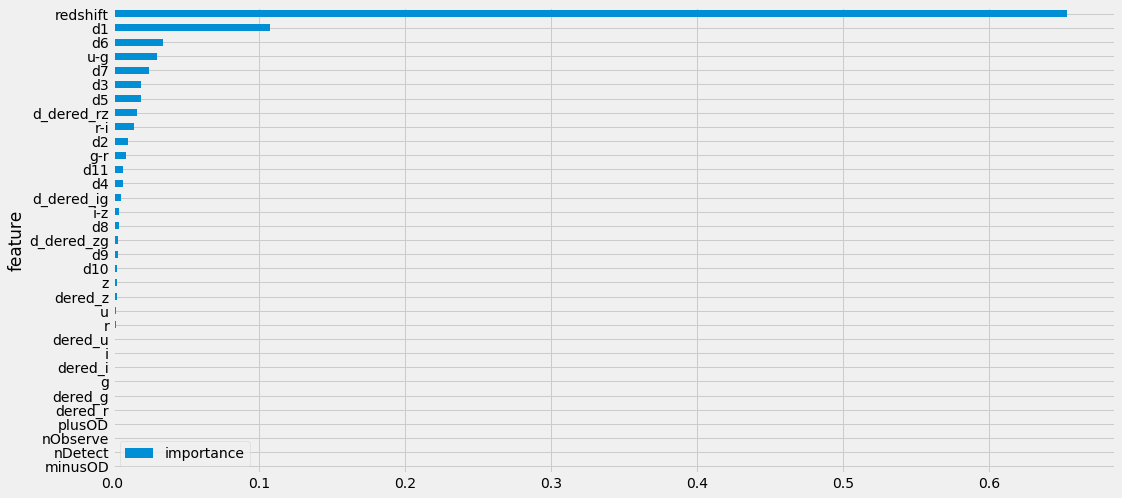

In [23]:
imp = pd.DataFrame({'feature': train2.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [24]:
sub = pd.read_csv(r"C:\Users\scott\Desktop\dankook_dacon\dataset\sample_submission.csv")
sub["class"] = p_tst
sub

,id,class
0,320000,0.0000
1,320001,1.0000
2,320002,0.0000
3,320003,1.0000
4,320004,0.0000
...,...,...
79995,399995,1.0000
79996,399996,0.0214
79997,399997,1.0000
79998,399998,0.0000


In [25]:
sub.to_csv("random_forest.csv", index=False)